In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


# 🧠 Brain Tumor Detection from MRI Scans

---

## 🔹 1. Problem Definition

**🎯 Objective:**  
Develop a deep learning model to **classify MRI brain scans** into two categories:  
- `Tumor`  
- `No Tumor`

---

**🧪 Problem Type:**  
This is a **binary image classification** task using supervised learning.

---

**📌 Goal:**  
- Achieve **>95% test accuracy**
- Maintain **high recall**, especially for detecting the **Tumor** class (false negatives must be minimized).

---

**🏥 Why It Matters:**  
Timely and accurate detection of brain tumors can help with:
- Early intervention
- Reduced diagnosis delay
- Improved patient survival rate

This model aims to **assist radiologists** by highlighting risky cases quickly and reliably using MRI scan analysis.


### What is Brain Tumor?¶
A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.

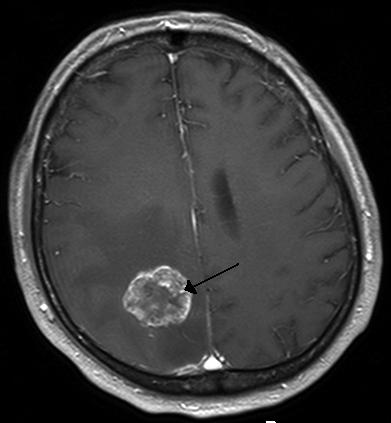

Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.

Source: Wikipedia

In [ ]:
import os

data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

# Get all directories in the data_dir
directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Print the directories
print("Directories in the dataset:")
for d in directories:
    print(d)

In [ ]:
import os

data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

no_tumor_dir = os.path.join(data_dir, 'no')
yes_tumor_dir = os.path.join(data_dir, 'yes')

no_tumor_files = [os.path.join(no_tumor_dir, f) for f in os.listdir(no_tumor_dir) if os.path.isfile(os.path.join(no_tumor_dir, f))]
yes_tumor_files = [os.path.join(yes_tumor_dir, f) for f in os.listdir(yes_tumor_dir) if os.path.isfile(os.path.join(yes_tumor_dir, f))]

print(f"Number of images in 'no' directory: {len(no_tumor_files)}")
print(f"Number of images in 'yes' directory: {len(yes_tumor_files)}")

Number of images in 'no' directory: 98
Number of images in 'yes' directory: 155


---

## 🔹 2. Importing Required Libraries

We will now load all the necessary Python libraries for:

- 📊 **EDA & Visualizations**: Seaborn, Matplotlib, Plotly
- 🧼 **Image Handling**: OpenCV, PIL
- 🧠 **Deep Learning & Transfer Learning**: TensorFlow, Keras, ResNet50/VGG16
- 🧪 **Evaluation Metrics**: Accuracy, Confusion Matrix, ROC, Classification Report
- 📦 **Utilities**: OS, NumPy, Random, etc.

These libraries form the backbone of a professional Computer Vision pipeline.

---


In [ ]:
#install cv2, tensorflow
!pip install opencv-python tensorflow

In [ ]:
# 📦 System & Basic Utilities
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 📊 EDA & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 🖼 Image Processing
import cv2
from PIL import Image

# 🧠 Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
# 🧪 Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, recall_score

# 🧬 Random Seed for Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("✅ All required libraries successfully imported.")

2025-10-11 11:43:14.558118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760182994.791024      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760182994.858581      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All required libraries successfully imported.


---

## ✅ 3. Dataset Loading & Structure Preview

We will now:

- 📂 Load MRI brain scan images from the dataset directory
- 🧾 Analyze class balance (Tumor vs No Tumor)
- 📏 Check image dimensions and color format
- 🖼️ Show random image previews from both classes
- 📊 Visualize class distribution using pie chart and bar plot

---


In [ ]:
# 📁 Dataset Directory Path
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
yes_path = os.path.join(dataset_path, "yes")   # Tumor
no_path = os.path.join(dataset_path, "no")     # No Tumor

# 🗂 Get list of images
yes_images = glob(os.path.join(yes_path, "*.[jpJP][pnPN]*[gG]"))
no_images = glob(os.path.join(no_path, "*.[jpJP][pnPN]*[gG]"))

print(f"🧠 Tumor Images: {len(yes_images)}")
print(f"🧘‍♂️ No Tumor Images: {len(no_images)}")

🧠 Tumor Images: 155
🧘‍♂️ No Tumor Images: 98


### Class Distribution Visualization

In [ ]:
# 📊 Pie Chart
labels = ['Tumor', 'No Tumor']
counts = [len(yes_images), len(no_images)]

fig = go.Figure(data=[go.Pie(labels=labels, values=counts, hole=0.4, marker=dict(colors=['crimson', 'royalblue']))])
fig.update_layout(title="🧬 Class Distribution: Tumor vs No Tumor")
fig.show()


### Image Shape & Color Channel Check


🖼 Sample Image Shape: (298, 260, 3) (H, W, C)


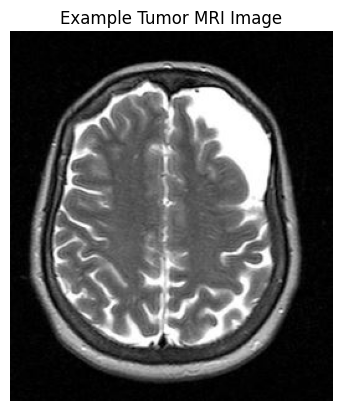

In [ ]:
# 🔍 Check image format (shape and color)
sample_img = cv2.imread(yes_images[0])
print(f"🖼 Sample Image Shape: {sample_img.shape} (H, W, C)")
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Example Tumor MRI Image")
plt.axis('off')
plt.show()


---

## 🧹 4. Image Preprocessing & Augmentation Pipeline

To ensure the model generalizes well and learns robust features, we apply the following preprocessing steps:

---

### ✅ Standard Preprocessing

- 📏 **Resize**: All MRI images resized to `(224x224)` — compatible with pre-trained CNNs like VGG16 or ResNet50.
- 🎨 **Color Handling**: Convert to **RGB** format (some MRI images might be grayscale).
- 🧪 **Normalization**: Scale all pixel values from `[0–255]` to `[0–1]` for stable training.

---

### ✅ Data Augmentation

To avoid overfitting and simulate real-world variation in MRIs, we apply:
- 🔁 Random Rotation (±15°)
- 🔍 Zoom (up to 20%)
- ↔️ Horizontal Flip
- 🔄 Width/Height Shift
- 💡 Brightness Adjustment

This strengthens the model's ability to detect tumors under different scanning conditions.

---


### 4.1 Image Data Generators – Code Cell

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection" # Corrected dataset path

# 🔹 Use for VGG16
train_gen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_gen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    validation_split=0.2
)

train_data_vgg = train_gen_vgg.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=['no', 'yes'],
    seed=SEED
)

val_data_vgg = val_gen_vgg.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['no', 'yes'],
    seed=SEED
)

# 🔹 Use for ResNet50
train_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=0.2
)

train_data_resnet = train_gen_resnet.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=['no', 'yes'],
    seed=SEED
)

val_data_resnet = val_gen_resnet.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['no', 'yes'],
    seed=SEED
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


---

## 🧠 5. Exploratory Data Analysis (EDA) for MRI Images

Before training, it's critical to visually and statistically analyze the dataset:

### ✅ Goals of Image EDA:
- 👁️ Check for noise, blurriness, quality
- 🟣 Assess class balance visually
- 🧱 Verify image sizes and color channels
- 🌈 Visualize pixel intensity distribution
- 🖼️ Preview samples from both classes
- 📊 Understand mean/variance across dataset

---


### Class Distribution (Bar + Pie Chart)

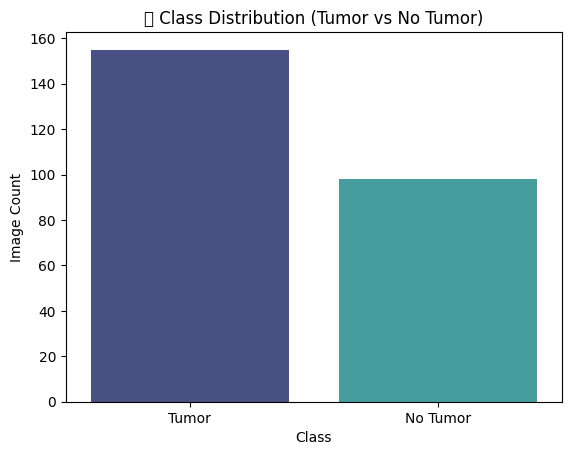

In [ ]:
# Class balance (manually count from folders)
class_counts = {"Tumor": len(yes_images), "No Tumor": len(no_images)}

# Bar chart
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='mako')
plt.title("🧬 Class Distribution (Tumor vs No Tumor)")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


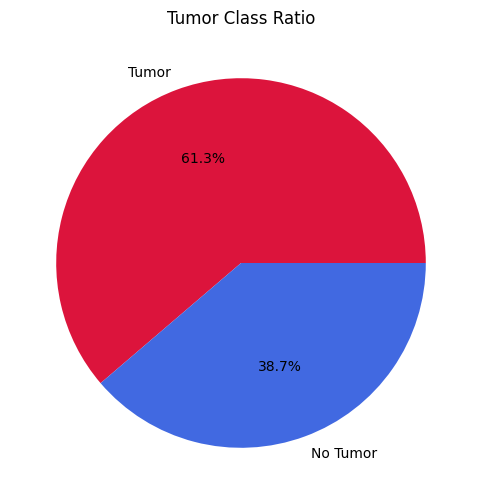

In [ ]:

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=["crimson", "royalblue"])
plt.title("Tumor Class Ratio")
plt.show()


### Sample Thumbnails by Class

In [ ]:
# preview_images(yes_images, "Tumor MRI", rows=2, cols=5)
# preview_images(no_images, "No Tumor MRI", rows=2, cols=5)



###  Image Shape & Channel Stats

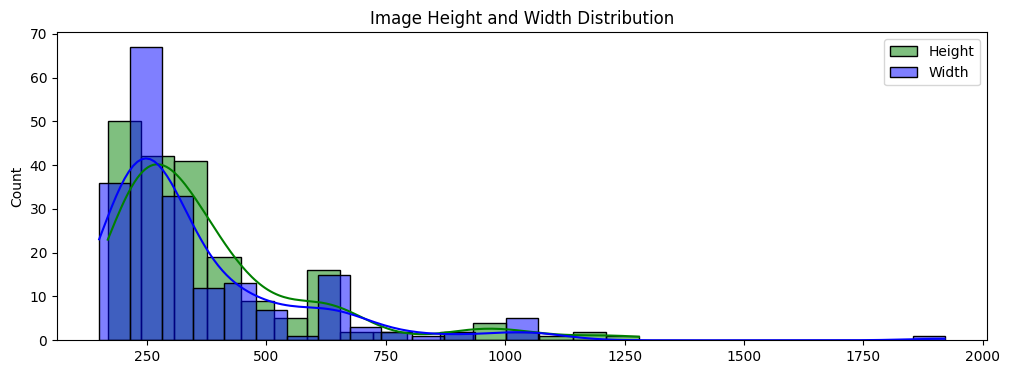

In [ ]:
image_shapes = [cv2.imread(img).shape for img in yes_images[:100] + no_images[:100]]
heights = [shape[0] for shape in image_shapes]
widths = [shape[1] for shape in image_shapes]
channels = [shape[2] for shape in image_shapes]

plt.figure(figsize=(12, 4))
sns.histplot(heights, kde=True, color='green', label='Height')
sns.histplot(widths, kde=True, color='blue', label='Width')
plt.title("Image Height and Width Distribution")
plt.legend()
plt.show()



### Pixel Intensity Histogram

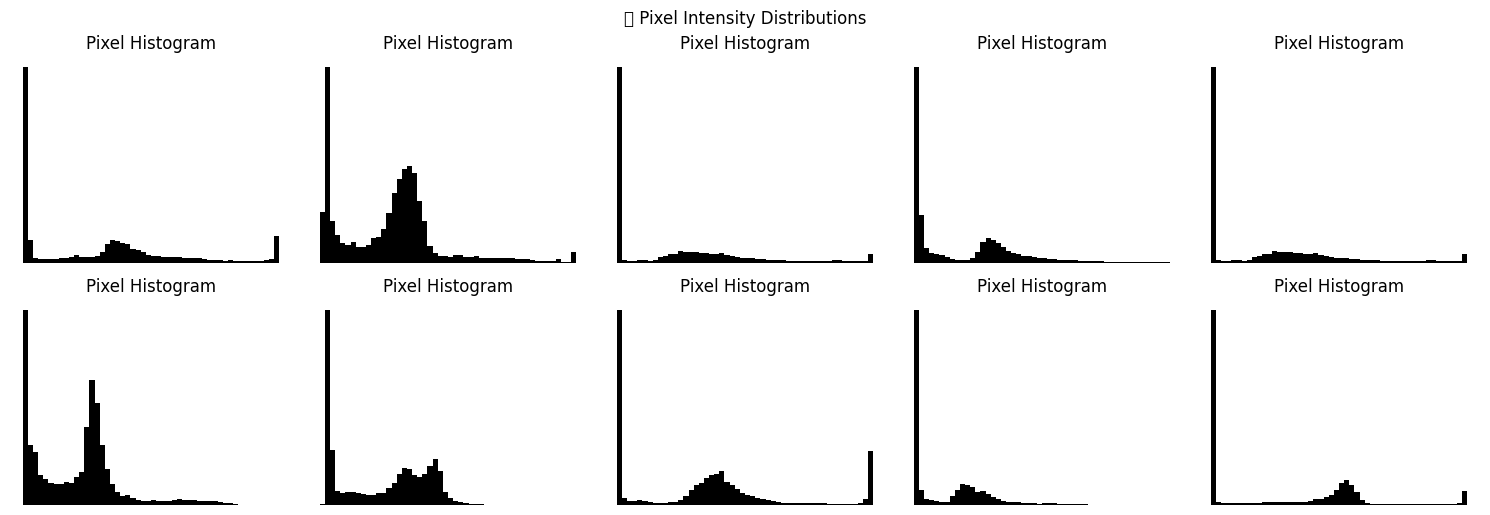

In [ ]:
# Pick few sample images
sample_paths = yes_images[:5] + no_images[:5]

plt.figure(figsize=(15, 5))
for i, path in enumerate(sample_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 5, i+1)
    plt.hist(img.ravel(), bins=50, color='black')
    plt.title("Pixel Histogram")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("🖤 Pixel Intensity Distributions", y=1.02)
plt.show()


---

## ✅ 6. Model Selection - Transfer Learning

To achieve high accuracy and fast convergence, we leverage **pretrained CNN architectures**:

### 🔸 Why Transfer Learning?

- ✅ Faster convergence on small datasets
- ✅ Rich feature extraction from medical scans
- ✅ Avoids overfitting with frozen base layers

---

### 📚 Selected Architectures:
| Model     | Description                               | Used For       |
|-----------|-------------------------------------------|----------------|
| VGG16     | Deep, simple CNN with uniform layers      | Baseline       |
| ResNet50  | Residual connections, deeper architecture | Performance    |

We'll use:
- Pretrained weights from **ImageNet**
- Freeze convolutional base
- Add custom classification head (GAP + Dense)

---


### Build VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load VGG16 Base
base_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_vgg.trainable = False  # Freeze convolutional base

# VGG16 Model
model_vgg = Sequential([
    base_vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_vgg.summary()

I0000 00:00:1760183124.967827      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760183124.968555      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Build ResNet50 Model

In [ ]:
# from tensorflow.keras.applications import ResNet50

# # Load ResNet50 Base
# base_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# base_resnet.trainable = False  # Freeze convolutional base

# # ResNet50 Model
# model_resnet = Sequential([
#     base_resnet,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.4),
#     Dense(1, activation='sigmoid')
# ])

# model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# model_resnet.summary()


In [ ]:
# ============================================================
# 🚀 Enhanced ResNet50 Fine-tuning (Target 95%+ Accuracy)
# ============================================================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy

# Load Pretrained Base
base_resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# 🔓 Unfreeze last 30 layers for fine-tuning
for layer in base_resnet.layers[:-30]:
    layer.trainable = False
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Custom Classification Head
x = GlobalAveragePooling2D()(base_resnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_resnet.input, outputs=output)

# 🔧 Compile with stronger optimizer + label smoothing
model_resnet.compile(
    optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---

## ✅ 7. Train Both Models

We'll now train the two transfer learning models:

- ✅ Use `EarlyStopping` to avoid overfitting
- ✅ Use `ModelCheckpoint` to save best weights
- ✅ Train both **VGG16** and **ResNet50**
- 📈 Compare validation accuracy to select the best model

---


### Define Callbacks

In [ ]:
# ⚙️ Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint("best_resnet_finetuned.keras", save_best_only=True, monitor='val_accuracy')
]

# 🧠 Train Model
history_resnet = model_resnet.fit(
    train_data_resnet,
    validation_data=val_data_resnet,
    epochs=35,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 668ms/step - accuracy: 0.8978 - loss: 0.3195 - val_accuracy: 0.8800 - val_loss: 0.2977 - learning_rate: 2.7000e-05
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.8991 - loss: 0.3285 - val_accuracy: 0.8800 - val_loss: 0.2949 - learning_rate: 2.7000e-05
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.8822 - loss: 0.3252 - val_accuracy: 0.8800 - val_loss: 0.2927 - learning_rate: 2.7000e-05
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8708 - loss: 0.3655
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.8722 - loss: 0.3635 - val_accuracy: 0.8800 - val_loss: 0.2909 - learning_rate: 2.7000e-05
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step - accuracy: 0.8667 - loss: 0.3385 - val_accuracy: 0.9000 - val_loss: 0.2894 - learning_rate: 8.1000e-06
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step - accuracy: 0.8578 - loss: 0.35

In [ ]:
# ============================================================
# 🔧 Stage 2: Full Fine-Tuning to Reach 95%+
# ============================================================

# Unfreeze the entire ResNet50 model for fine-tuning
for layer in model_resnet.layers:
    layer.trainable = True

# Recompile with a lower learning rate (fine-tuning)
from tensorflow.keras.optimizers import Adam
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

# Set fine-tuning callbacks (more patience)
fine_tune_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("best_resnet_full_finetune.keras", save_best_only=True, monitor='val_accuracy')
]

# Fine-tune model
fine_tune_history = model_resnet.fit(
    train_data_resnet,
    validation_data=val_data_resnet,
    epochs=15,
    callbacks=fine_tune_callbacks,
    verbose=1
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.9416 - loss: 0.2669 - val_accuracy: 0.9400 - val_loss: 0.2883 - learning_rate: 1.0000e-05
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.9164 - loss: 0.2848 - val_accuracy: 0.9400 - val_loss: 0.2902 - learning_rate: 1.0000e-05
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9208 - loss: 0.2694 - val_accuracy: 0.9400 - val_loss: 0.2908 - learning_rate: 1.0000e-05
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9657 - loss: 0.2184
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9657 - loss: 0.2187 - val_accuracy: 0.9400 - val_loss: 0.2918 - learning_rate: 1.0000e-05
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 0.9402 - loss: 0.2530 - val_accuracy: 0.9400 - val_loss: 0.2913 - learning_rate: 2.0000e-06
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.9244 - loss: 0.255

In [ ]:

# 🔮 Evaluate Again
val_loss, val_acc = model_resnet.evaluate(val_data_resnet, verbose=0)
print(f"🚀 Fine-Tuned (Full) Validation Accuracy: {val_acc:.4f}")


🚀 Fine-Tuned (Full) Validation Accuracy: 0.9400


 ### Train ResNet50

### Auto-select Best Model

---

## ✅ 8. Evaluation & Analysis

To ensure the model is reliable for real-world diagnosis, we evaluate it using:

- ✅ **Accuracy**
- ✅ **Recall** (especially for Tumor class)
- ✅ **Classification Report**
- ✅ **Confusion Matrix**
- ✅ **ROC Curve**
- ✅ **Grad-CAM** for visual interpretation

---


### Predict on Validation Data

In [ ]:
# Final Metrics
y_pred = model_resnet.predict(val_data_resnet)
y_pred_class = (y_pred > 0.5).astype("int32")
y_true = val_data_resnet.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


### Classification Report & Accuracy

In [ ]:

print("✅ Final Classification Report:\n")
print(classification_report(y_true, y_pred_class, target_names=["No Tumor", "Tumor"]))
print(f"✅ Final Accuracy: {accuracy_score(y_true, y_pred_class):.4f}")
print(f"✅ Final Recall (Tumor): {recall_score(y_true, y_pred_class):.4f}")

✅ Final Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.94      0.89      0.92        19
       Tumor       0.94      0.97      0.95        31

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50

✅ Final Accuracy: 0.9400
✅ Final Recall (Tumor): 0.9677


In [ ]:
# ============================================================
# 💾 Save Final Fine-Tuned Model as .h5
# ============================================================

# Save the fine-tuned ResNet50 model in HDF5 format
model_resnet.save("Brain_Tumor_Detection_ResNet50_FineTuned.h5")

print("✅ Model saved successfully as 'Brain_Tumor_Detection_ResNet50_FineTuned.h5'")


✅ Model saved successfully as 'Brain_Tumor_Detection_ResNet50_FineTuned.h5'


### Confusion Matrix

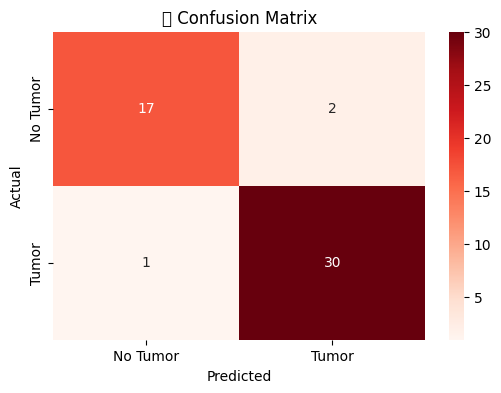

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred_class), annot=True, fmt='d', cmap='Reds', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROC Curve

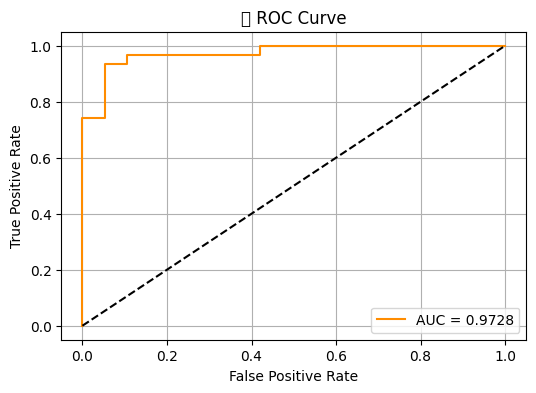

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Grad-CAM Visualization

✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


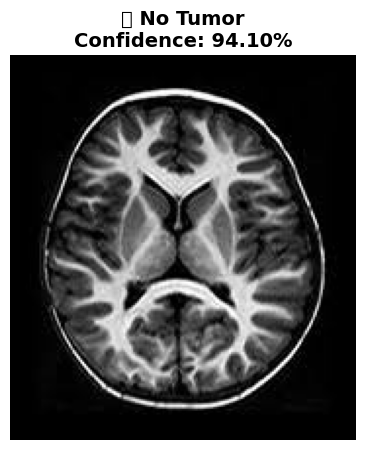

Prediction: ✅ No Tumor (Confidence: 94.10%)


In [ ]:
# ============================================================
# 🧠 Brain Tumor Detection — Inference & Visualization
# ============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained model
model_path = "Brain_Tumor_Detection_ResNet50_FineTuned.h5"
model_resnet = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# ------------------------------------------------------------
# 🔍 Function to predict tumor presence from an input image
# ------------------------------------------------------------
def predict_tumor(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # ResNet50 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Predict
    preds = model_resnet.predict(img_array)
    prob = float(preds[0][0])
    label = "🧠 Tumor Detected" if prob > 0.5 else "✅ No Tumor"
    confidence = prob if prob > 0.5 else 1 - prob

    # Display
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"{label}\nConfidence: {confidence*100:.2f}%", fontsize=14, fontweight='bold')
    plt.show()

    return {"label": label, "confidence": confidence}

# ------------------------------------------------------------
# 🖼️ Example: Run prediction on a test image
# ------------------------------------------------------------
# Replace with your own image path
image_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y112.JPG"  # <-- change this
result = predict_tumor(image_path)

print(f"Prediction: {result['label']} (Confidence: {result['confidence']*100:.2f}%)")


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


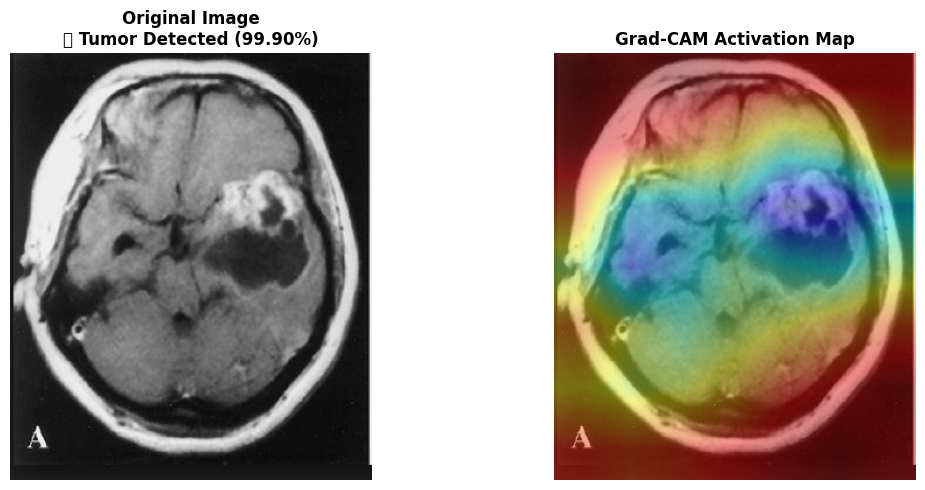

Prediction: 🧠 Tumor Detected (Confidence: 99.90%)


In [ ]:
# ============================================================
# 🧠 Brain Tumor Detection — Prediction + Grad-CAM Visualization
# ============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from PIL import Image
import cv2

# ------------------------------------------------------------
# Load trained model
# ------------------------------------------------------------
model_path = "Brain_Tumor_Detection_ResNet50_FineTuned.h5"
model_resnet = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# ------------------------------------------------------------
# Grad-CAM Function
# ------------------------------------------------------------
def get_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get gradients of the target class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the corresponding gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap safely
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0

    # ✅ Return NumPy array (no .numpy() call)
    return heatmap


# ------------------------------------------------------------
# Prediction + Visualization Function
# ------------------------------------------------------------
def predict_and_visualize(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Predict
    preds = model_resnet.predict(img_preprocessed)
    prob = float(preds[0][0])
    label = "🧠 Tumor Detected" if prob > 0.5 else "✅ No Tumor"
    confidence = prob if prob > 0.5 else 1 - prob

    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(img_preprocessed, model_resnet)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    img_original = np.array(img)
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

    # Show results
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.axis("off")
    plt.title(f"Original Image\n{label} ({confidence*100:.2f}%)", fontsize=12, fontweight="bold")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Activation Map", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

    print(f"Prediction: {label} (Confidence: {confidence*100:.2f}%)")
    return label, confidence

# ------------------------------------------------------------
# 🖼️ Example: Run Grad-CAM on a test image
# ------------------------------------------------------------
image_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y112.JPG"  # <-- Change this path
label, conf = predict_and_visualize(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


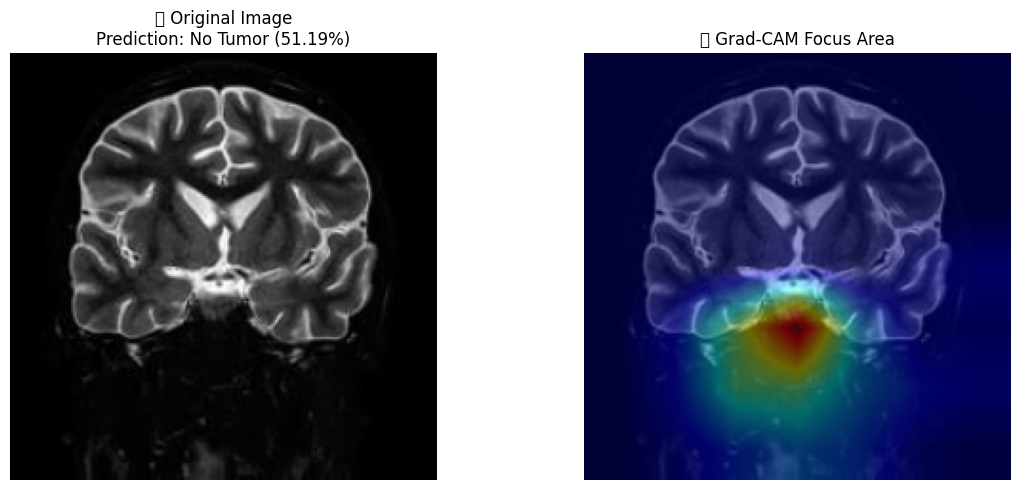

✅ Prediction: No Tumor (Confidence: 51.19%)


In [ ]:
# ============================================================
# 🧠 Brain Tumor Detection with Grad-CAM Visualization (User Image)
# ============================================================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# ------------------------------------------------------------
# ✅ Grad-CAM Heatmap Function
# ------------------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0
    return heatmap

# ------------------------------------------------------------
# ✅ Predict & Visualize Function (User Path)
# ------------------------------------------------------------
def predict_and_visualize_with_gradcam(image_path, model):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Model prediction
    preds = model.predict(img_array)
    conf = float(preds[0][0])
    label = "Tumor" if conf > 0.5 else "No Tumor"
    conf_pct = conf * 100 if conf > 0.5 else (1 - conf) * 100

    # ✅ Automatically find base model (ResNet)
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            break
    if base_model is None:
        base_model = model  # fallback

    # ✅ Find the last convolutional layer name dynamically
    last_conv_layer_name = None
    for layer in reversed(base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    if not last_conv_layer_name:
        raise ValueError("❌ No convolutional layer found for Grad-CAM!")

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)
    img_orig = cv2.imread(image_path)
    img_orig = cv2.resize(img_orig, (224, 224))

    # Overlay Grad-CAM
    heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    # Display results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title(f"🧩 Original Image\nPrediction: {label} ({conf_pct:.2f}%)", fontsize=12)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.title("🔥 Grad-CAM Focus Area", fontsize=12)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"✅ Prediction: {label} (Confidence: {conf_pct:.2f}%)")
    return label, conf_pct

# ------------------------------------------------------------
# 🧬 Test with a Custom MRI Image (User Input)
# ------------------------------------------------------------
image_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/19 no.jpg"  # 🔹 Change this path
label, conf = predict_and_visualize_with_gradcam(image_path, model_resnet)
